In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# plotly (interactive plot)
from plotly.offline import init_notebook_mode, iplot
import plotly.plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

,a,b,z
0,52,51,1
1,55,54,1
2,61,45,1
3,40,62,0
4,43,59,0


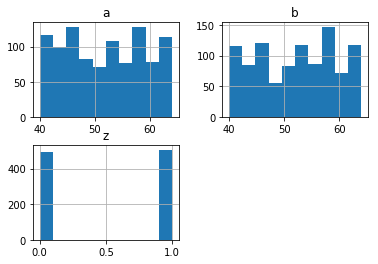

In [2]:
np.random.seed(0)
num_data = 1000
min_value = 40
max_value = 65
threshold = 110
a = np.random.randint(low=min_value, high=max_value, size=[num_data])
b = np.random.randint(low=min_value, high=max_value, size=[num_data])


def convertToBinary(input) :
    if input>threshold:
        return 1
    else:
        return 0
# gen output
z = []
actual_z = []
for i in range(len(a)):
    current_actual_z = 5*a[i] - 3*b[i] + 10
    actual_z.append(current_actual_z)
    z.append(convertToBinary(current_actual_z))
    
z = np.array(z).T

# display data
data = np.array([a,b,z]).T
data = pd.DataFrame(data, columns=['a','b','z'])
data.hist(bins=10)
data.head()

In [3]:
trace = go.Mesh3d(x=a,
                   y=b,
                   z=actual_z,
                   opacity=1,
                   color='rgba(100,22,244,0.6)'
                  )
trace_threshold = go.Mesh3d(x=[min_value, min_value, max_value, max_value],
                   y=[min_value, max_value, min_value,max_value],
                   z=[threshold,threshold,threshold,threshold],
                   opacity=.5,
                   color='rgba(244,22,100,0.6)'
                  )
iplot([trace,trace_threshold])

In [4]:
trace = go.Scatter3d( x=a,
                   y=b,
                   z=z,
                   mode='markers',
                    marker=dict(
                        size=4,
                        line=dict(
                            color='rgba(217, 217, 217, 256)',
                            width=0.5
                        ),
                        opacity=0.8
                    )
                  )
data=[trace]
iplot(data)

In [5]:
feature_a = tf.feature_column.numeric_column('a')
feature_b = tf.feature_column.numeric_column('b')
features = [feature_a, feature_b]

### 1. Train

In [6]:
input_func = tf.estimator.inputs.numpy_input_fn( x={
                                                    'a': a,
                                                    'b': b
                                                 },
                                                 y=z,
                                                 batch_size=1000,
                                                 num_epochs=3000,
                                                 shuffle=True)
optimizer = tf.train.AdamOptimizer(learning_rate=3)
model = tf.estimator.LinearClassifier(feature_columns=features, optimizer=optimizer)
model.train(input_fn=input_func,steps=999999)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716826/T/tmpy3m5yjg8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x118238a20>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716

### 1.1 Weight

In [8]:
var_names = tf.estimator.LinearClassifier.get_variable_names(model)
for name in var_names:
    var_value = tf.estimator.LinearClassifier.get_variable_value(model, name)
    print(name, var_value)

w_a = np.asscalar(tf.estimator.LinearClassifier.get_variable_value(model, 'linear/linear_model/a/weights'))
w_b = np.asscalar(tf.estimator.LinearClassifier.get_variable_value(model, 'linear/linear_model/b/weights'))
bias = np.asscalar(tf.estimator.LinearClassifier.get_variable_value(model, 'linear/linear_model/bias_weights'))
print('weigth a :', w_a)
print('weigth b :', w_b)
print('weigth bias :', bias)

global_step 3000
linear/beta1_power 0.0
linear/beta2_power 0.04966469
linear/linear_model/a/weights [[10.20673]]
linear/linear_model/a/weights/part_0/Adam [[42.3847]]
linear/linear_model/a/weights/part_0/Adam_1 [[3998533.5]]
linear/linear_model/b/weights [[-6.4220514]]
linear/linear_model/b/weights/part_0/Adam [[37.984776]]
linear/linear_model/b/weights/part_0/Adam_1 [[4173591.]]
linear/linear_model/bias_weights [-196.57974]
linear/linear_model/bias_weights/part_0/Adam [1.3986663]
linear/linear_model/bias_weights/part_0/Adam_1 [1496.0823]
weigth a : 10.206729888916016
weigth b : -6.422051429748535
weigth bias : -196.57974243164062


### 2. Test

In [9]:
test_input_func = tf.estimator.inputs.numpy_input_fn(
    x={
    'a': a,
    'b': b
    },
    y=z,
    batch_size=1000,
    num_epochs=1000,
    shuffle=False)
eval_metrics = model.evaluate(input_fn=test_input_func,steps=1)
eval_metrics

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-10-03:06:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716826/T/tmpy3m5yjg8/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-04-10-03:06:02
INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.977, accuracy_baseline = 0.506, auc = 0.993053, auc_precision_recall = 0.9965533, average_loss = 0.09723675, global_step = 3000, label/mean = 0.506, loss = 97.236755, prediction/mean = 0.48207673


{'accuracy': 0.977,
 'accuracy_baseline': 0.506,
 'auc': 0.993053,
 'auc_precision_recall': 0.9965533,
 'average_loss': 0.09723675,
 'label/mean': 0.506,
 'loss': 97.236755,
 'prediction/mean': 0.48207673,
 'global_step': 3000}

### 3. Prediction

In [10]:
input_fn_predict = tf.estimator.inputs.numpy_input_fn(x={
    'a':np.array([50]),
    'b':np.array([50])
},shuffle=False)
predict = model.predict(input_fn=input_fn_predict)

for p in predict:
    print(p)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716826/T/tmpy3m5yjg8/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'logits': array([-7.345825], dtype=float32), 'logistic': array([0.00064486], dtype=float32), 'probabilities': array([9.9935514e-01, 6.4486451e-04], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object)}


### 4. Plot prediction vs actual value

In [11]:
z_prediction = []
for i in range(len(a)):
    current_actual_z = w_a*a[i] + w_b*b[i] + bias
    z_prediction.append(current_actual_z)

In [12]:
trace1 = go.Mesh3d(x=a,
                   y=b,
                   z=actual_z,
                   opacity=1,
                   color='rgba(0,22,244,0.6)'
                  )
trace2 = go.Mesh3d(x=a,
                   y=b,
                   z=z_prediction,
                   opacity=1,
                   color='rgba(100,244,22,0.6)'
                  )
trace_threshold = go.Mesh3d(x=[min_value,min_value,max_value,max_value],
                   y=[min_value,max_value,min_value,max_value],
                   z=[threshold,threshold,threshold,threshold],
                   opacity=.5,
                   color='rgba(244,22,100,0.6)'
                  )
trace_sigmoid_threshold = go.Mesh3d(x=[min_value,min_value,max_value,max_value],
                   y=[min_value,max_value,min_value,max_value],
                   z=[0,0,0,0],
                   opacity=.5,
                   color='rgba(0,244,244,0.6)'
                  )
iplot([trace1, trace2, trace_threshold, trace_sigmoid_threshold])

### Conclusion
 1. As the graph shows, bias, w1, w2, ... may be not equal to the actual equation. But the lines on the threshold plane are the same
 2. Skew class 0 and 1 does matter the performance

# Develop Our Own Net

In [125]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape,stddev=0.1) # random as normal distribution but only in 2SD
    return tf.Variable(init_random_dist, name="WEIGHT")
def init_bias(shape):
    init_bias_vals = tf.constant(0.1,shape=shape)
    return tf.Variable(init_bias_vals, name="BIAS")

def normal_full_layer(input_layer, output_size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, output_size])
    b = init_bias([output_size])
    return tf.matmul(input_layer, W) + b

In [126]:
x = tf.placeholder(tf.float32, shape=[None, 2])
y_true = tf.placeholder(tf.float32, shape=[None, 1])
y_pred = tf.nn.sigmoid(normal_full_layer(x, 1))
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred, name="SIGMOID_ACTIVATION")

# Loss Function
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
train = optimizer.minimize(loss)

In [127]:
x_data = np.array([a,b]).T
z_data = np.array([z]).T
print(z_data.shape, x_data.shape)

(1000, 1) (1000, 2)


In [128]:
# Session
steps = 201
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(steps):
        sess.run(train, feed_dict={x:x_data, y_true: z_data})
        
        # print output every 100 steps
        if i%100 == 0:
            print('Currently on step {}'.format(i))
            print('Accuracy is ')
            
            
#             y_pred_sess = sess.run(y_pred, feed_dict={x: x_data, y_true: z_data})
#             print(np.array(y_pred_sess).min(),np.array(y_pred_sess).max())

#             print( sess.run(loss, feed_dict={x: x_data, y_true: z_data}))

            
            matches = tf.equal(y_pred, y_true)
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            print(sess.run(acc, feed_dict={x: x_data, y_true: z_data}))
            print('\n')
    
    all_vars= tf.global_variables()
    print( sess.run([all_vars[0],all_vars[1]]) )
    

Currently on step 0
Accuracy is 
0.0


Currently on step 100
Accuracy is 
0.0


Currently on step 200
Accuracy is 
0.0


[array([[-0.01784271],
       [ 0.04593569]], dtype=float32), array([0.1], dtype=float32)]
